## Use MNIST dataset to try classification models

In [60]:
#Regular EDA / plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

In [61]:
#Fetch the dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [62]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

(-0.5, 27.5, 27.5, -0.5)

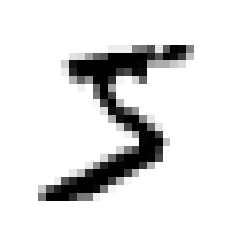

In [63]:
first_digit = X[0]
first_digit_image = first_digit.reshape(28,28)

plt.imshow(first_digit_image, cmap="binary")
plt.axis("off") #Remove axis from image

In [64]:
y = y.astype(np.uint8)

In [65]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a binary classifier

In [66]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [67]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(random_state=42,n_jobs=-1)
sgd_model.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
sgd_model.predict([first_digit])

array([ True])

### Performance measures

In [69]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_model, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [70]:
#A model that classifies everything to "not-5"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_model = Never5Classifier()
cross_val_score(never_5_model, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

* This explains why "accuracy" is not preferred as an evaluation method, especially when dealing with **skewed** datasets.

### Confusion Matrix

In [71]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_model, X_train, y_train_5, cv=3)

In [72]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [73]:
from sklearn.metrics import recall_score, precision_score, f1_score

def cm_scores(labels, preds):
    print("Precision: {}".format(precision_score(labels, preds)))
    print("Recall:    {}".format(recall_score(labels, preds)))
    print("F1 score:  {}".format(f1_score(labels, preds)))

cm_scores(y_train_5, y_train_pred)

Precision: 0.8370879772350012
Recall:    0.6511713705958311
F1 score:  0.7325171197343846


* Precision/Recall tradeoff

In [74]:
y_scores = sgd_model.decision_function([first_digit])
y_scores

array([2164.22030239])

In [75]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [76]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [77]:
#To decide which threshold to use, get decision_function via cross_val_predict
y_scores = cross_val_predict(sgd_model, X_train, y_train_5, cv=3, method="decision_function")

In [78]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [79]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "r-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threashold", fontsize=16)
    plt.style.use('seaborn-dark')
    plt.axis([-50000, 50000, 0, 1])

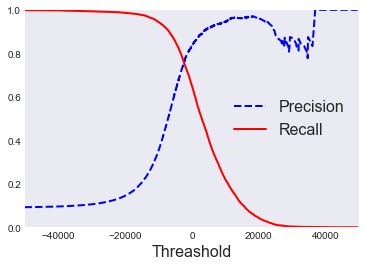

In [80]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [81]:
#look for the lowest threshold that gives 90% precision.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [82]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [83]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [84]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

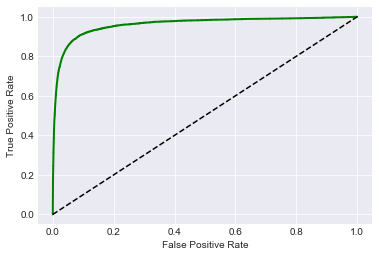

In [85]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, color="g")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate", fontsize=10)
    plt.ylabel("True Positive Rate", fontsize=10)
    plt.style.use('seaborn-dark')
    plt.grid(True)
plot_roc_curve(fpr, tpr)

In [86]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [87]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [88]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

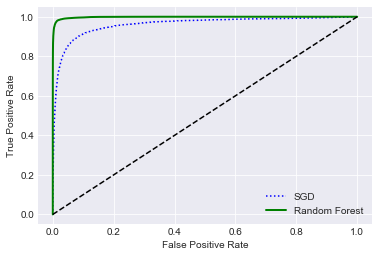

In [89]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [90]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Multiclass Classification

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])